In [1]:
from fish_helpers import *
import time
from functools import partial
from multiprocessing import Pool
import pylab as pl
from IPython import display
import tqdm.notebook as tqdm
import math
import random
import operator
import matplotlib._color_data as mcd
base_path = '/bigstore/GeneralStorage/Zach/MERCI/Distance/'
if not os.path.exists(base_path):
    os.mkdir(base_path)

In [2]:
import scanpy as sc
sc.settings.verbosity = 3

In [3]:
data_path = '/bigstore/GeneralStorage/Zach/MERCI/PRJNA434002/'
adata = sc.read(os.path.join(data_path,'matrix.mtx'), cache=False)
adata = adata.transpose()
adata.X = adata.X.toarray()
barcodes = pd.read_csv(os.path.join(data_path,'barcodes.tsv'), header=None, sep='\t')
genes = pd.read_csv(os.path.join(data_path,'genes.tsv'), header=None, sep='\t')

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


In [9]:
barcodes.head()

,0
0,AAACCTGGTCCATGAT-1_5981_BA9
1,AAACGGGAGTAGCCGA-1_5981_BA9
2,AAACGGGCATCGGTTA-1_5981_BA9
3,AAACGGGTCCATGAAC-1_5981_BA9
4,AAAGATGCACGACTCG-1_5981_BA9


In [10]:
genes.head()

,0,1
0,ENSG00000223972,DDX11L1
1,ENSG00000227232,WASH7P
2,ENSG00000278267,MIR6859-3
3,ENSG00000243485,RP11-34P13.3
4,ENSG00000274890,MIR1302-9


In [13]:
barcodes.rename(columns={0:'barcode'}, inplace=True)
barcodes.set_index('barcode', inplace=True)
adata.obs = barcodes
genes.rename(columns={0:'gene_id', 1:'gene_symbol'}, inplace=True)
genes.set_index('gene_symbol', inplace=True)
adata.var = genes

In [14]:
adata.obs

""
barcode
AAACCTGGTCCATGAT-1_5981_BA9
AAACGGGAGTAGCCGA-1_5981_BA9
AAACGGGCATCGGTTA-1_5981_BA9
AAACGGGTCCATGAAC-1_5981_BA9
AAAGATGCACGACTCG-1_5981_BA9
...
TTTGTCAGTGTTAAGA-1_MS200_A303
TTTGTCAGTTCGCGAC-1_MS200_A303
TTTGTCAGTTCTGGTA-1_MS200_A303


In [25]:
meta = pd.read_csv(os.path.join(data_path,'meta.tsv'), sep='\t')
meta.rename(columns={'cell':'barcode'},inplace=True)
meta.index = meta['barcode']
meta = meta.drop(columns='barcode')
meta.head()

,cluster,sample,individual,region,age,sex,diagnosis,Capbatch,Seqbatch,post-mortem interval (hours),RNA Integrity Number,genes,UMIs,RNA mitochondr. percent,RNA ribosomal percent
barcode,,,,,,,,,,,,,,,
AAACCTGGTACGCACC-1_1823_BA24,Neu-NRGN-II,1823_BA24,1823,ACC,15,M,Control,CB8,SB3,18,7.0,622,774,2.454780,1.421189
AAACGGGCACCAGATT-1_1823_BA24,L5/6,1823_BA24,1823,ACC,15,M,Control,CB8,SB3,18,7.0,6926,24042,0.445055,0.428417
AAAGATGAGTCCAGGA-1_1823_BA24,Oligodendrocytes,1823_BA24,1823,ACC,15,M,Control,CB8,SB3,18,7.0,624,830,0.240964,0.722892
AAAGATGTCTTGAGGT-1_1823_BA24,OPC,1823_BA24,1823,ACC,15,M,Control,CB8,SB3,18,7.0,1192,1771,0.225861,1.806889
AAAGCAAGTAATCACC-1_1823_BA24,Oligodendrocytes,1823_BA24,1823,ACC,15,M,Control,CB8,SB3,18,7.0,691,895,0.558659,0.670391


In [26]:
for i in meta.columns:
    adata.obs[i] = meta[i]

In [27]:
adata.obs

,cluster,sample,individual,region,age,sex,diagnosis,Capbatch,Seqbatch,post-mortem interval (hours),RNA Integrity Number,genes,UMIs,RNA mitochondr. percent,RNA ribosomal percent
barcode,,,,,,,,,,,,,,,
AAACCTGGTCCATGAT-1_5981_BA9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACGGGAGTAGCCGA-1_5981_BA9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACGGGCATCGGTTA-1_5981_BA9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACGGGTCCATGAAC-1_5981_BA9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAAGATGCACGACTCG-1_5981_BA9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCAGTGTTAAGA-1_MS200_A303,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TTTGTCAGTTCGCGAC-1_MS200_A303,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TTTGTCAGTTCTGGTA-1_MS200_A303,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
[i for i in meta.index if i in adata.obs.index]

[]

In [31]:
base_path = '/bigstore/GeneralStorage/Zach/MERCI/Autism/'
MeA_AllCells_DGE_SizeNorm = pickle.load(open(os.path.join(base_path,'MeA_AllCells_DGE_SizeNorm.pkl'),'rb'))
MeA_AllCells_DGE_SizeNorm = MeA_AllCells_DGE_SizeNorm.astype('float32')
MeA_AllCells_DGE_SizeNorm.head()

,GGATAGTCCAGA_M1_N,TAACGACATTCG_M1_N,CGTTCGTTCGAC_M1_N,CTGCAGTATTTT_M1_N,CCTATGGGGATA_M1_N,TAGCGATTCTTG_M1_N,AATGACGTATAG_M1_N,ATATACTAACTT_M1_OL,AGTATCTTTATT_M1_N,CCGGTTAAGCTT_M1_OL,...,GTGGTTGAACAG_F7_AS,AGATCCTTTAGA_F7_OL,GCGGTCGCGTTA_F7_N,GAATTAGGTGCT_F7_AS,GTCTTTGCGAGT_F7_N,GAGTGTAGTCGN_F7_AS,CATGAAGATGCC_F7_N,CGATCGAGATAA_F7_N,ATACTGTTAGCT_F7_AS,TCTCTAATCAAA_F7_AS
0610005C13Rik,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
0610007N19Rik,0.000000,2.940139,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
0610007P14Rik,4.763095,14.700694,5.318772,0.000000,12.108370,11.922859,6.307557,14.189932,5.269814,26.857655,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
0610009B22Rik,9.526191,8.820416,12.410467,0.000000,6.054185,5.961430,3.153778,7.094966,0.000000,2.984184,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
0610009D07Rik,14.289287,23.521111,12.410467,12.528189,15.135463,20.865004,22.076448,7.094966,21.079258,23.873470,...,0.0,0.0,0.0,367.647064,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
cells = []
samples = []
cell_types = []
for cell in MeA_AllCells_DGE_SizeNorm.columns:
    c,s,t = cell.split('_')
    cells.append(cell)
    samples.append(s)
    cell_types.append(t)
np.unique(cell_types)
info_df = pd.DataFrame(index=cells)
info_df['cells'] = cells
info_df['samples'] = samples
info_df['cell_types'] = cell_types
info_df['barcode'] = [i.split('_')[0] for i in info_df['cells']]
info_df

,cells,samples,cell_types,barcode
GGATAGTCCAGA_M1_N,GGATAGTCCAGA_M1_N,M1,N,GGATAGTCCAGA
TAACGACATTCG_M1_N,TAACGACATTCG_M1_N,M1,N,TAACGACATTCG
CGTTCGTTCGAC_M1_N,CGTTCGTTCGAC_M1_N,M1,N,CGTTCGTTCGAC
CTGCAGTATTTT_M1_N,CTGCAGTATTTT_M1_N,M1,N,CTGCAGTATTTT
CCTATGGGGATA_M1_N,CCTATGGGGATA_M1_N,M1,N,CCTATGGGGATA
...,...,...,...,...
GAGTGTAGTCGN_F7_AS,GAGTGTAGTCGN_F7_AS,F7,AS,GAGTGTAGTCGN
CATGAAGATGCC_F7_N,CATGAAGATGCC_F7_N,F7,N,CATGAAGATGCC
CGATCGAGATAA_F7_N,CGATCGAGATAA_F7_N,F7,N,CGATCGAGATAA
ATACTGTTAGCT_F7_AS,ATACTGTTAGCT_F7_AS,F7,AS,ATACTGTTAGCT


In [95]:
base_path='/bigstore/GeneralStorage/Zach/MERCI/MERGI'
I=0
while os.path.exists(os.path.join(base_path,str('elite_survivor_'+str(I)+'.pkl'))):
    I+=1
I-=1
elite_survivor = pickle.load(open(os.path.join(base_path,str('elite_survivor_'+str(I)+'.pkl')),'rb'))
survivors = pickle.load(open(os.path.join(base_path,str('survivors_'+str(I)+'.pkl')),'rb'))
metrics = pickle.load(open(os.path.join(base_path,str('metrics_'+str(I)+'.pkl')),'rb'))
encodings = pickle.load(open(os.path.join(base_path,str('encodings_'+str(I)+'.pkl')),'rb'))


In [96]:
I

4

In [97]:
encodings[0].head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
GGATAGTCCAGA_M1_N,245.293945,172.653320,134.555664,104.771484,230.986328,201.218750,139.318359,177.416016,208.361328,290.556641,207.170898,253.603516,172.642578,191.714844,135.729492,195.268555,179.786133,183.380859
TAACGACATTCG_M1_N,274.891602,179.334961,208.750977,98.486328,261.649414,204.342773,144.057617,147.001953,221.975586,295.469727,217.541992,232.256836,144.070312,149.930664,146.986328,196.978516,136.711914,138.188477
CGTTCGTTCGAC_M1_N,260.641602,150.717773,173.741211,117.009766,202.104492,182.599609,132.958008,141.829102,191.470703,299.666992,235.829102,271.262695,159.569336,173.744141,166.657227,216.294922,145.366211,164.894531
CTGCAGTATTTT_M1_N,318.251953,135.302734,165.380859,77.687500,140.333984,197.945312,122.792969,182.929688,197.949219,290.628906,313.175781,280.648438,150.369141,185.408203,127.798828,152.857422,122.791016,185.425781
CCTATGGGGATA_M1_N,296.644531,105.937500,124.101562,115.042969,245.210938,208.847656,118.066406,205.839844,193.726562,311.781250,257.261719,263.339844,142.285156,139.238281,145.289062,205.875000,175.574219,175.566406


In [98]:
cell_type_df = pd.DataFrame(index=info_df.cell_types.unique(),columns=encodings[0].columns)
cell_type_std_df = pd.DataFrame(index=info_df.cell_types.unique(),columns=encodings[0].columns)
for cell_type in info_df.cell_types.unique():
    temp_df = encodings[0]
    cells = list(info_df[info_df.cell_types==cell_type].index)
    cell_type_df.loc[cell_type] = np.average(temp_df.loc[cells],axis=0)
    cell_type_std_df.loc[cell_type] = np.std(temp_df.loc[cells],axis=0)
cell_type_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
N,200.533,213.361,210.655,104.696,129.294,144.967,124.535,140.005,187.071,308.748,165.002,225.189,186.864,149.421,120.22,202.132,118.779,114.22
OL,206.865,124.094,137.307,136.888,214.249,167.529,181.096,171.097,210.56,172.572,109.285,224.38,130.427,232.725,296.293,219.805,99.7847,131.695
OPC-OL,300.154,204.581,164.949,87.9591,124.771,236.696,186.807,229.055,153.465,245.012,171.85,650.582,225.815,218.804,353.763,196.198,131.759,147.817
OPC,257.068,238.495,213.275,109.573,126.647,230.091,191.943,288.171,173.646,215.117,247.725,270.63,248.316,207.509,286.009,242.797,179.051,143.259
EN,210.549,147.983,186.706,124.568,125.59,249.57,159.577,304.703,165.043,140.791,149.394,526.283,374.615,150.899,140.497,237.702,151.308,155.901
MU,573.173,176.087,187.513,95.0634,134.378,216.628,305.675,310.99,179.196,228.606,148.321,316.21,158.459,176.971,181.68,206.139,117.854,132.936
AS,181.589,293.612,207.27,110.836,92.2316,160.562,180.132,182.822,133.862,168.059,193.604,185.423,173.1,175.362,126.611,275.635,180.128,112.227
MG,240.992,174.964,172.255,96.7797,94.4562,135.798,138.696,287.815,204.958,152.967,148.846,215.284,140.141,199.664,213.099,176.602,143.087,139.729


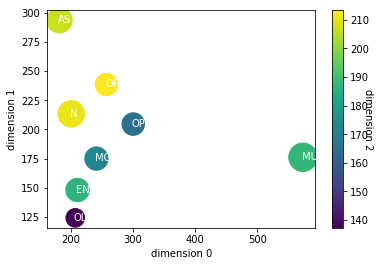

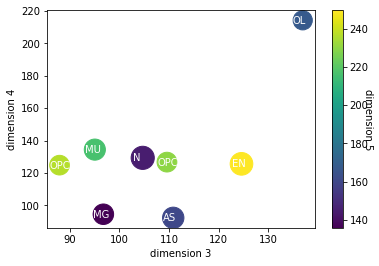

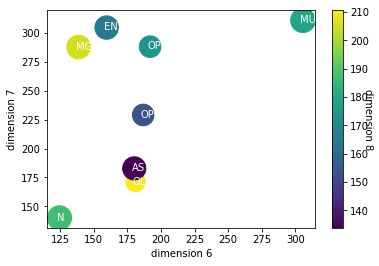

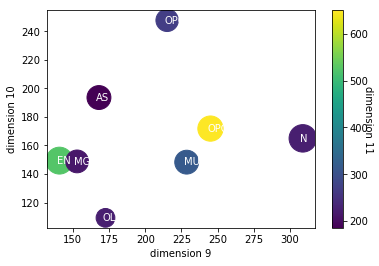

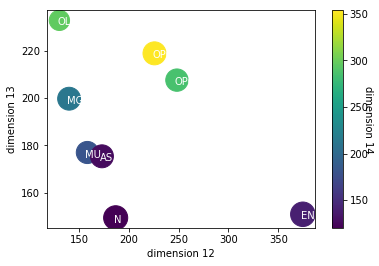

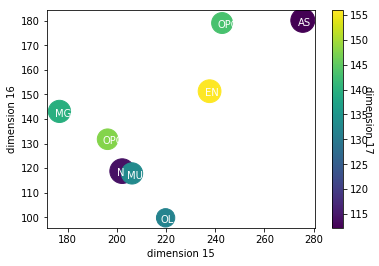

In [99]:
a=-2
for i in cell_type_df.columns:
    if i%3==0:
        x = cell_type_df[i]
        y = cell_type_df[i+1]
        c = list(cell_type_df[i+2])
        s = list(cell_type_std_df[i]+cell_type_std_df[i+1]+cell_type_std_df[i+2])
        plt.scatter(x,y,c=c,s=s)
        plt.xlabel('dimension '+str(i))
        plt.ylabel('dimension '+str(i+1))
        cbar = plt.colorbar()
        cbar.set_label('dimension '+str(i+2), rotation=270)
        for i, txt in enumerate(cell_type_df.index):
            plt.annotate(txt, (x[i]+a, y[i]+a),color='w')
        plt.show()

In [190]:
distance_df = encodings[0]
s = int(len(distance_df.index)*0.01)
correlations = []
for cell in random.sample(list(distance_df.index),s):
    if 'blank' in cell:
        continue
    distance_vector = np.sqrt(np.sum((distance_df-distance_df.loc[cell])**2,axis=1))
    knn = list(distance_vector.sort_values(ascending=True)[:10].index)
    for cell in knn[1:]:
        correlations.append(spearmanr(MeA_AllCells_DGE_SizeNorm[knn[0]],MeA_AllCells_DGE_SizeNorm[cell])[0])
print('Average Correlation:',round(np.average(correlations),4))
print('Standard Deviation:',round(np.std(correlations),4))

Average Correlation: 0.1632
Standard Deviation: 0.1062


In [192]:
distance_df = encodings[0]
s = int(len(distance_df.index)*0.01)
correlations = []
for cell in random.sample(list(distance_df.index),s):
    if 'blank' in cell:
        continue
    distance_vector = np.sqrt(np.sum((distance_df-distance_df.loc[cell])**2,axis=1))
    knn = list(distance_vector.sort_values(ascending=True)[:10].index)
    for cell in knn[1:]:
        correlations.append(0)
#         correlations.append(spearmanr(MeA_AllCells_DGE_SizeNorm[knn[0]],MeA_AllCells_DGE_SizeNorm[cell])[0])
print('Average Correlation:',round(np.average(correlations),4))
print('Standard Deviation:',round(np.std(correlations),4))

Average Correlation: 0.0
Standard Deviation: 0.0


In [ ]:
def qc_pfunc(self,cell):
    correlations = []
    distance_df = self.encodings[0]
    distance_vector = np.sqrt(np.sum((distance_df-distance_df.loc[cell])**2,axis=1))
    knn = list(distance_vector.sort_values(ascending=True)[:self.k].index)
    for cell in knn[1:]:
        correlations.append(spearmanr(self.scmatrix[knn[0]],self.scmatrix[cell])[0])
    return correlations

def qc_viewer(self):
    correlations = []
    distance_df = self.encodings[0]
    cells = random.sample(self.cells,self.sample_size)
    for cell in cells:
        distance_vector = np.sqrt(np.sum((distance_df-distance_df.loc[cell])**2,axis=1))
        knn = list(distance_vector.sort_values(ascending=True)[:self.k].index)
        for cell in knn[1:]:
            correlations.append(spearmanr(self.scmatrix[knn[0]],self.scmatrix[cell])[0])
    if self.ncpu==1:
        for cell in tqdm.tqdm(self.population): #possible parallel place
            correlations.extend(self.qc_pfunc(cell))
    else:
        sys.stdout.flush()
        with Pool(self.ncpu) as p:
            for temp_correlations in  tqdm.tqdm(p.imap(self.qc_pfunc,cells,chunksize=1),total=len(cells)):
                correlations.extend(temp_correlations)
        sys.stdout.flush()
    print('Average Correlation:',round(np.average(correlations),4))
    print('Standard Deviation:',round(np.std(correlations),4))

In [146]:
knn[0]

'CTATTCCCATAG_F5_OPC'

In [144]:
knn[0:]

['CTATTCCCATAG_F5_OPC',
 'AATGGTGGCTTN_M5_OPC',
 'CTGGAGCGGCCT_F3_OPC',
 'CCGCTTTCTGAG_F5_OPC',
 'CATGTTGGCAGG_M4_OPC',
 'CAGTGTGGTTTA_F6_OPC',
 'TTCCACTTCGCN_F5_OPC',
 'TACACACATTCA_M6_OPC',
 'GCATAAACATAA_F3_OPC',
 'GGCATTTACATC_F2_OPC']

In [136]:
spearmanr(MeA_AllCells_DGE_SizeNorm[knn[0]],MeA_AllCells_DGE_SizeNorm[cell])

SpearmanrResult(correlation=0.06216056699750071, pvalue=5.375987964082583e-16)

In [112]:
distance_df.loc[knn]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
TGCACAAGATTC_F2_OL,141.250000,105.937500,105.937500,282.437500,141.250000,282.500000,176.562500,141.250000,70.625000,105.937500,176.562500,353.062500,0.000000,176.562500,211.812500,247.187500,35.312500,141.187500
CCTTGAATGTAA_F4_OL,144.640625,126.546875,162.718750,235.062500,72.312500,180.796875,162.734375,180.796875,180.781250,108.468750,216.968750,361.593750,36.156250,235.078125,253.187500,144.625000,54.234375,162.750000
AAGACAGGCCTG_M4_OL,200.593750,171.906250,85.968750,171.937500,171.906250,229.250000,171.906250,114.625000,85.968750,143.281250,85.968750,372.531250,114.625000,229.218750,143.281250,257.906250,85.968750,200.562500
TTCTAATCGGGT_F7_OL,202.312500,67.437500,101.156250,168.593750,202.312500,236.000000,168.593750,202.312500,101.156250,134.843750,202.312500,168.593750,67.437500,202.312500,235.937500,202.281250,33.718750,168.562500
GATGTATGACCA_M4_OL,167.343750,100.406250,133.875000,251.031250,234.312500,184.062500,100.406250,66.937500,117.140625,133.859375,117.140625,317.921875,117.140625,284.453125,200.781250,167.343750,100.406250,150.578125
CTTTCCTATATT_M2_OL,219.109375,116.875000,146.078125,131.484375,102.265625,189.890625,189.890625,219.156250,160.671875,116.859375,116.843750,292.140625,43.828125,204.531250,306.812500,204.515625,73.046875,116.859375
TCGCATTACGAC_F3_OL,178.625000,133.968750,111.656250,156.312500,111.656250,200.953125,156.312500,200.968750,133.984375,111.640625,111.640625,290.250000,178.625000,156.312500,267.984375,267.968750,66.984375,156.296875
GTCCCTCGTGAA_M5_OL,37.187500,185.937500,148.750000,223.062500,260.312500,297.500000,297.500000,148.750000,185.937500,111.562500,185.937500,297.500000,0.000000,185.875000,260.312500,185.937500,111.562500,148.750000
CGTTCATTATTT_M2_OL,224.023438,144.976562,171.312500,158.109375,118.609375,237.203125,210.859375,144.976562,224.046875,92.257812,171.312500,250.390625,79.078125,144.960938,250.414062,316.289062,105.437500,131.789062
TTCCCGTAGATC_M2_OL,210.875000,120.500000,90.375000,210.875000,210.875000,180.750000,90.375000,120.500000,150.625000,90.375000,60.250000,421.750000,150.625000,210.875000,241.000000,271.125000,60.250000,180.750000


In [113]:
for cell in knn:
    print(knn[0],cell)
    print(spearmanr(MeA_AllCells_DGE_SizeNorm[knn[0]],MeA_AllCells_DGE_SizeNorm[cell]))

TGCACAAGATTC_F2_OL TGCACAAGATTC_F2_OL
SpearmanrResult(correlation=1.0, pvalue=0.0)
TGCACAAGATTC_F2_OL CCTTGAATGTAA_F4_OL
SpearmanrResult(correlation=0.3442339766708689, pvalue=0.0)
TGCACAAGATTC_F2_OL AAGACAGGCCTG_M4_OL
SpearmanrResult(correlation=0.3267156741781765, pvalue=0.0)
TGCACAAGATTC_F2_OL TTCTAATCGGGT_F7_OL
SpearmanrResult(correlation=0.3116436737219223, pvalue=0.0)
TGCACAAGATTC_F2_OL GATGTATGACCA_M4_OL
SpearmanrResult(correlation=0.3394541504580906, pvalue=0.0)
TGCACAAGATTC_F2_OL CTTTCCTATATT_M2_OL
SpearmanrResult(correlation=0.3675833708604208, pvalue=0.0)
TGCACAAGATTC_F2_OL TCGCATTACGAC_F3_OL
SpearmanrResult(correlation=0.3366445022394349, pvalue=0.0)
TGCACAAGATTC_F2_OL GTCCCTCGTGAA_M5_OL
SpearmanrResult(correlation=0.2972744592716071, pvalue=0.0)
TGCACAAGATTC_F2_OL CGTTCATTATTT_M2_OL
SpearmanrResult(correlation=0.3475617982056525, pvalue=0.0)
TGCACAAGATTC_F2_OL TTCCCGTAGATC_M2_OL
SpearmanrResult(correlation=0.3249269785411574, pvalue=0.0)


In [104]:
cell

'AAGACGGACAAT_M4_OPC'

In [103]:
MeA_AllCells_DGE_SizeNorm.head()

,GGATAGTCCAGA_M1_N,TAACGACATTCG_M1_N,CGTTCGTTCGAC_M1_N,CTGCAGTATTTT_M1_N,CCTATGGGGATA_M1_N,TAGCGATTCTTG_M1_N,AATGACGTATAG_M1_N,ATATACTAACTT_M1_OL,AGTATCTTTATT_M1_N,CCGGTTAAGCTT_M1_OL,...,GTGGTTGAACAG_F7_AS,AGATCCTTTAGA_F7_OL,GCGGTCGCGTTA_F7_N,GAATTAGGTGCT_F7_AS,GTCTTTGCGAGT_F7_N,GAGTGTAGTCGN_F7_AS,CATGAAGATGCC_F7_N,CGATCGAGATAA_F7_N,ATACTGTTAGCT_F7_AS,TCTCTAATCAAA_F7_AS
0610005C13Rik,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
0610007N19Rik,0.000000,2.940139,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
0610007P14Rik,4.763095,14.700694,5.318772,0.000000,12.108370,11.922859,6.307557,14.189932,5.269814,26.857655,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
0610009B22Rik,9.526191,8.820416,12.410467,0.000000,6.054185,5.961430,3.153778,7.094966,0.000000,2.984184,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
0610009D07Rik,14.289287,23.521111,12.410467,12.528189,15.135463,20.865004,22.076448,7.094966,21.079258,23.873470,...,0.0,0.0,0.0,367.647064,0.0,0.0,0.0,0.0,0.0,0.0


In [89]:
i

0

In [73]:
c

N         402.918
OL        248.487
OPC-OL    397.318
OPC       324.518
EN        442.538
MU        670.142
AS         372.43
MG        362.793
dtype: object

/home/zach/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


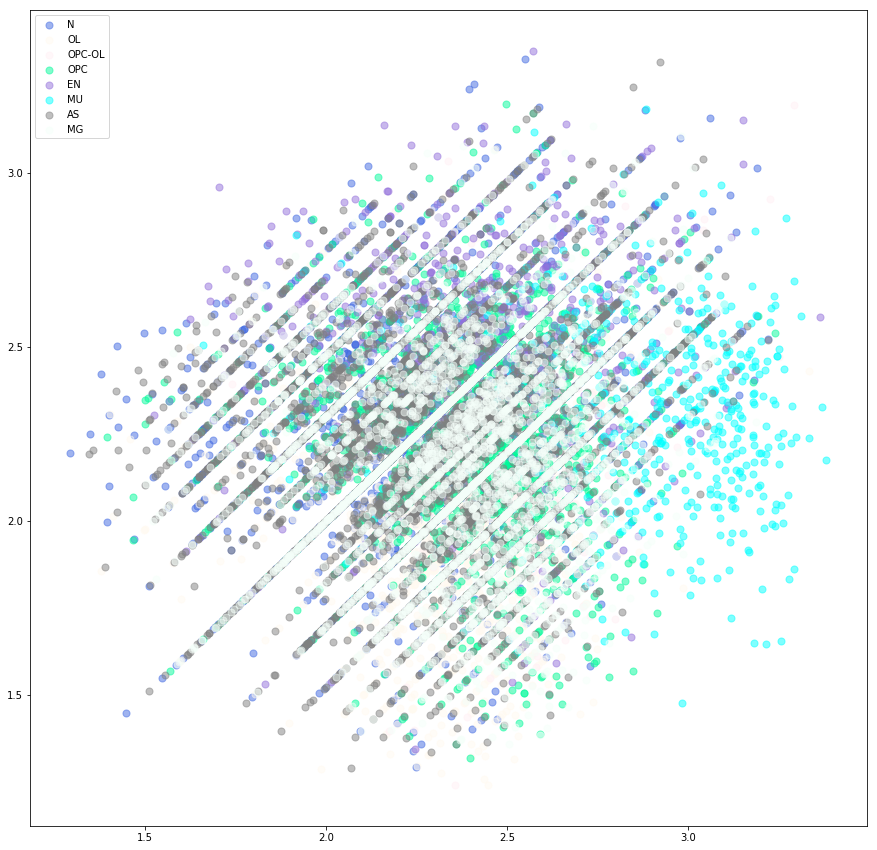

In [64]:
import matplotlib._color_data as mcd
plt.figure(figsize=[15,15])
for cell_type in info_df.cell_types.unique():
    temp_df = encodings[0]
    cells = list(info_df[info_df.cell_types==cell_type].index)
    color = random.sample(list(mcd.CSS4_COLORS.keys()),1)
    temp_df = temp_df.loc[cells]
    temp_df = np.log10(temp_df)
    plt.scatter(temp_df[0],temp_df[1],s=50,c=color,alpha=0.5,label=cell_type)
plt.legend()
plt.show()

/home/zach/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


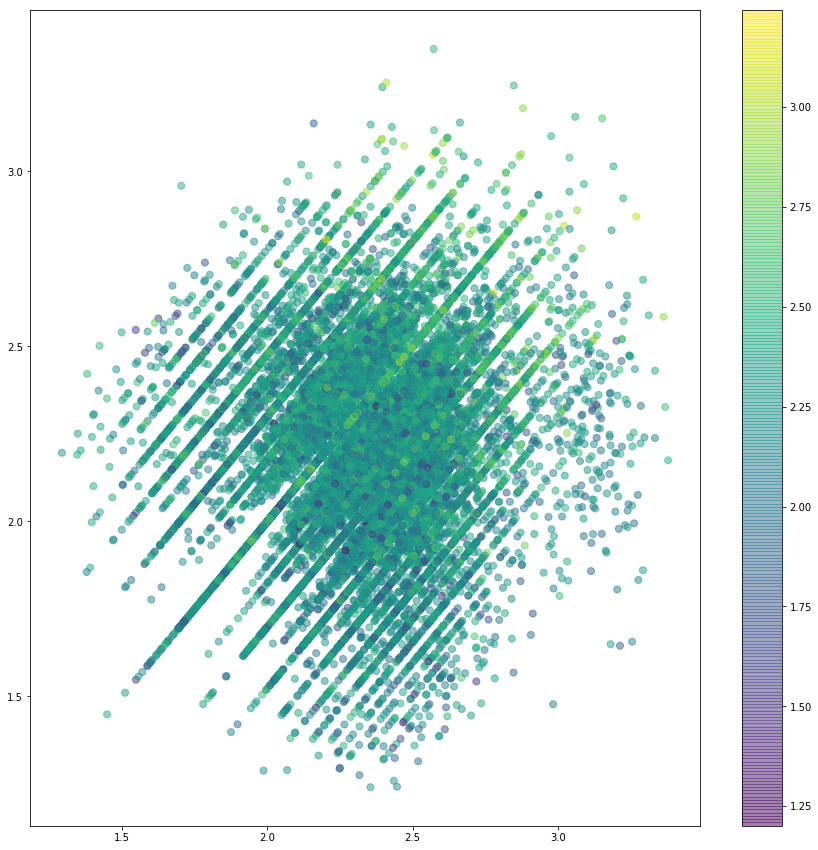

In [65]:
temp_df = np.log10(encodings[0])
plt.figure(figsize=[15,15])
plt.scatter(temp_df[0],temp_df[1],s=50,c=temp_df[2],alpha=0.5)
plt.colorbar()
plt.show()

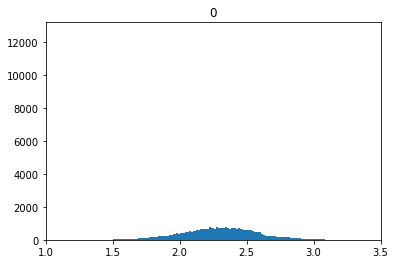

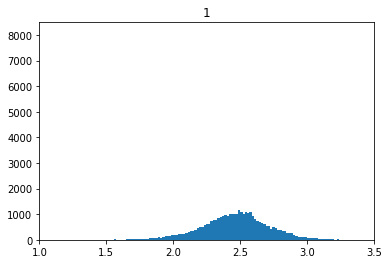

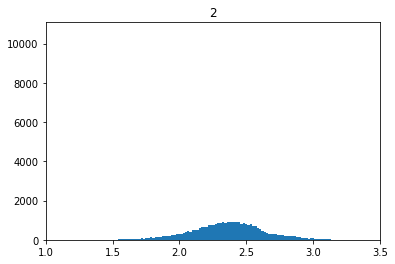

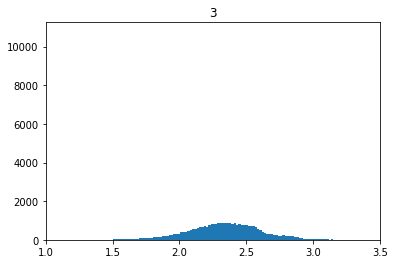

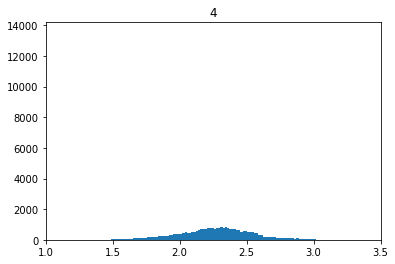

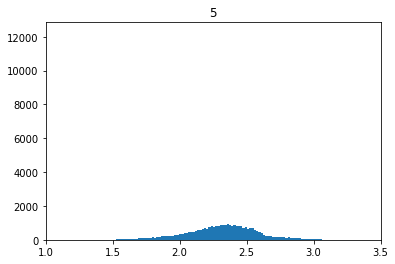

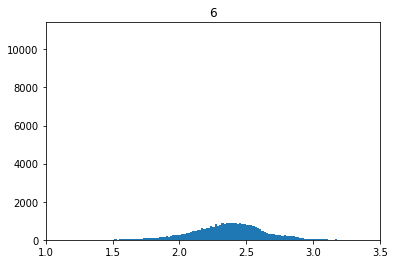

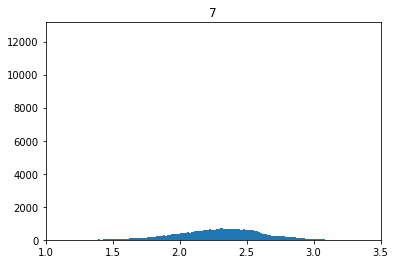

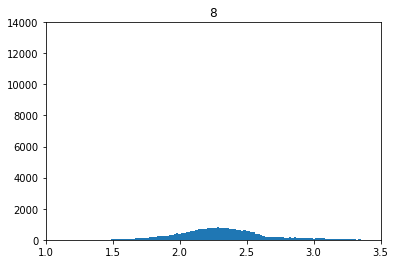

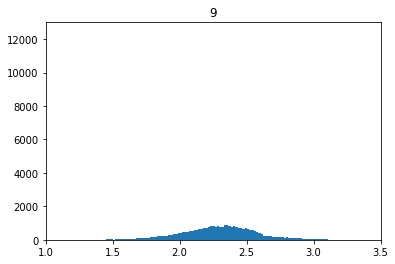

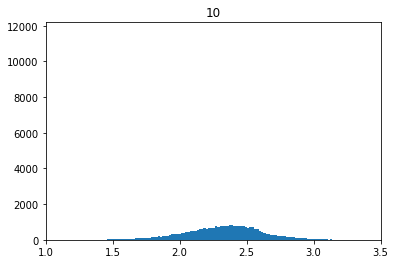

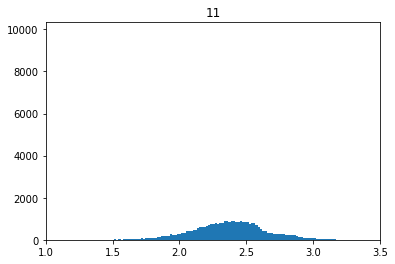

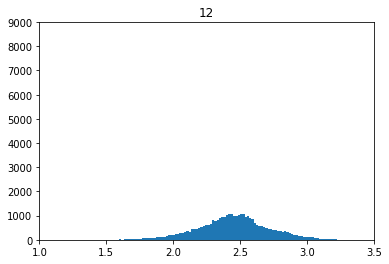

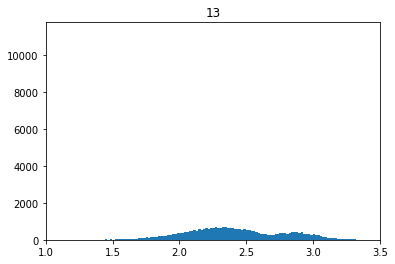

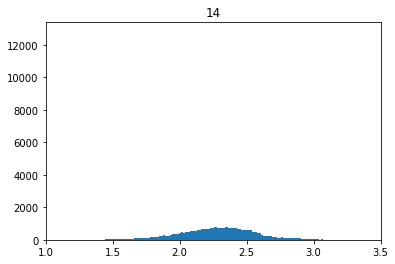

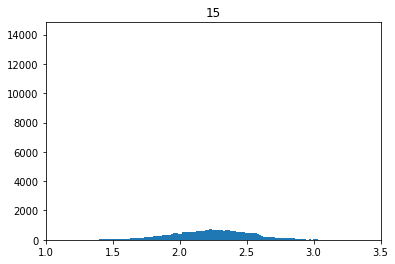

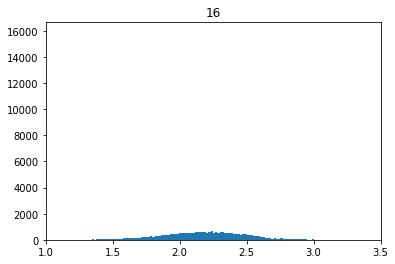

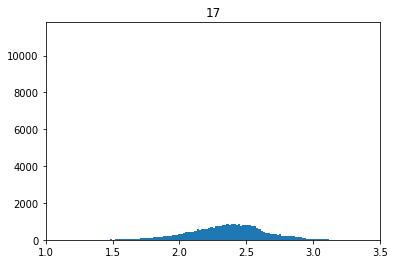

In [56]:
temp_df = encodings[0]
temp_df = np.log10(encodings[0]+1)
for i in temp_df.columns:
    plt.hist(temp_df[i],bins=200)
    plt.xlim(1,3.5)
    plt.title(i)
    plt.show()

In [193]:
from fish_helpers import *
barcodes = pd.read_csv('/home/zach/PythonRepos/PySpots/hybescope_config/MHD4_24bit_472cwords.csv',header=None)
barcodes.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,1,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,1,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,1,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,1,1
